<a href="https://colab.research.google.com/github/aswa09/EVA-4/blob/master/S14/EVA4_S15A_data_statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import Libraries

In [102]:
import os
import numpy as np
import pandas as pd
import glob
from zipfile import ZipFile
from PIL import Image
from tqdm.autonotebook import tqdm
from IPython.display import display
from IPython.display import Image as Dimage
import sys
from contextlib import closing

!pip install opencv-contrib-python --quiet
import cv2

### Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('./drive/My Drive/Colab Notebooks/S14/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Data path

In [3]:
ROOT_DATA_DIR = './images/'

FG_DIR=ROOT_DATA_DIR+'fg/'
FG_MASK_DIR=ROOT_DATA_DIR+'fg_mask/'
BG_DIR=ROOT_DATA_DIR+'bg/'
FG_BG_DIR=ROOT_DATA_DIR+'fg_bg/'
FG_BG_MASK_DIR=ROOT_DATA_DIR+'fg_bg_mask/'
FG_BG_DEPTH_DIR=ROOT_DATA_DIR+'fg_bg_depth/'

# Data Visualization

In [4]:
def visualise_imgs(images_list, grid_name, height=140, margin=8,list_lim=10,aspect_ratio=False,iszip=False):
  try:
    if iszip:
      zip_file=images_list[0]
      archive = ZipFile(zip_file, mode='r')
      images_list = archive.namelist()[:list_lim]
      for img in images_list:
        archive.extract(img)
      archive.close()

    widths = []
    if aspect_ratio:
      for img in images_list[:list_lim]:
        image = Image.open(img)
        h_percent = height / image.size[1]
        widths.append(int(image.size[0] * h_percent))
    else:
        widths = [height] * len(images_list)
    
    start = 0
    background = Image.new('RGBA', (sum(widths) + (list_lim - 1) * margin, height))
    
    for idx, img_path in enumerate(images_list[:list_lim]):
      image = Image.open(img_path)
      image = image.resize((widths[idx], height))
      offset = (start, 0)
      start += (widths[idx] + margin)
      background.paste(image, offset)
      if iszip:
        os.remove(img_path)
    background.save(f'{grid_name}_grid.png')
    return background
  except Exception as e:
    print('Error on line {}'.format(sys.exc_info()[-1].tb_lineno) + " " + type(e).__name__ + " " + str(e))
    sys.exit(1)

###Foreground

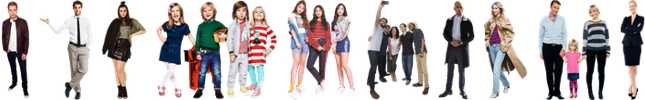

In [5]:
img_list=glob.glob(FG_DIR+'*')
visualise_imgs(img_list[:10], 'fg', height=100,aspect_ratio=True)

##Foreground masks

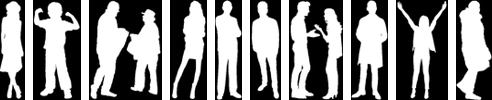

In [6]:
img_list=glob.glob(FG_MASK_DIR+'*')
visualise_imgs(img_list[:10], 'fg_mask', height=100,aspect_ratio=True)

##Background

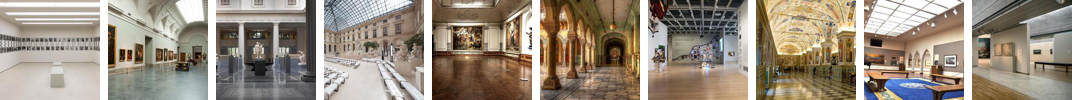

In [7]:
img_list=glob.glob(BG_DIR+'*')
visualise_imgs(img_list[:10], 'bg', height=100)

##Foreground-Background

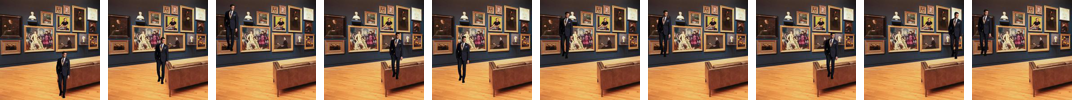

In [8]:
zip_file = glob.glob(FG_BG_DIR+'bg001.zip')
visualise_imgs(zip_file, 'fg_bg', height=100,iszip=True)

##Foreground Background Masks

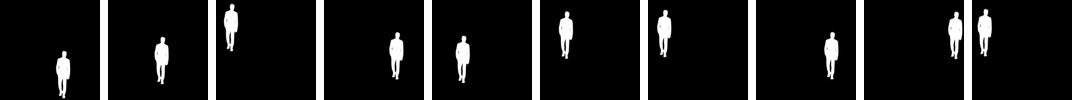

In [9]:
zip_file = glob.glob(FG_BG_MASK_DIR+'bg001.zip')
visualise_imgs(zip_file, 'fg_bg_mask', height=100,iszip=True)

##Foreground Background Depth images

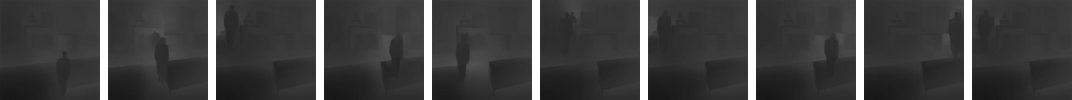

In [10]:
zip_file = glob.glob(FG_BG_DEPTH_DIR+'bg001.zip')
visualise_imgs(zip_file, 'fg_bg_depth', height=100,iszip=True)

# Data Statistics

Statistics computed for each type of image category.

*   Mean
*   Standard Deviation
*   total number of images

In [173]:
def statistics(filename, channel_num, filetype,iszip=False):
  try:
    counter = 0
    mean = []
    std = []
    images = []

    pixel_num = 0
    channel_sum = np.zeros(channel_num)
    channel_sum_squared = np.zeros(channel_num)

    if iszip:
      zip_file=glob.glob(filename+'*.zip')

      img_count=0
      for z in zip_file:
        with closing(ZipFile(z)) as archive2:
          img_count+= len(archive2.infolist())
        archive2.close()

      zip_file=zip_file[0]
      archive = ZipFile(zip_file, mode='r')
      images_list = archive.namelist()
      archive.close()
    else:
      images_list=glob.glob(filename+'*')
      img_count=len(images_list)

    if iszip:
        archive = ZipFile(zip_file, mode='r')
    for entry in tqdm(images_list):
      if iszip:
        file=archive.open(entry)
        img = Image.open(file)
      else:
        img = Image.open(entry)

      if len(images) < 5:
          images.append(img)
      im = np.array(img)
      im = im / 255.0
      pixel_num += (im.size / channel_num)
      channel_sum += np.sum(im, axis=(0, 1))
      channel_sum_squared += np.sum(np.square(im), axis=(0, 1))
      counter += 1
    
    if iszip:
      archive.close()

    bgr_mean = channel_sum / pixel_num
    bgr_std = np.sqrt(channel_sum_squared / pixel_num - np.square(bgr_mean))
        
    mean = [round(x, 5) for x in list(bgr_mean)[::-1]]
    std = [round(x, 5) for x in list(bgr_std)[::-1]]

    
    stats = {
    'File Type':[filetype],
    'Mean':[mean],
    'Standard deviation':[std],
    'Number of images':img_count,
    'Dimension':[im.shape]
    }
    data = pd.DataFrame.from_dict(stats)
    return data
  except Exception as e:
    print('Error on line {}'.format(sys.exc_info()[-1].tb_lineno) + " " + type(e).__name__ + " " + str(e))
    sys.exit(1)

# Statistics for Background images

In [164]:
print('Calculating statistics for Backgrounds:')
bg_df=statistics(BG_DIR, 3, 'Background')

Calculating statistics for Backgrounds:


# Statistics for Foreground images

In [165]:
print('Calculating statistics for Foregrounds:')
fg_df=statistics(FG_DIR, 3, 'Foreground')

Calculating statistics for Foregrounds:


# Statistics for Foreground Masks images

In [170]:
print('Calculating statistics for Foreground Masks:')
fg_m_df=statistics(FG_MASK_DIR, 1, 'Foreground Masks')

Calculating statistics for Foreground Masks:


# Statistics for Background-Foreground images

In [171]:
print('Calculating statistics for Background-Foreground Images:')
fbg_df=statistics(FG_BG_DIR, 3, 'Background-Foreground',iszip=True)

Calculating statistics for Background-Foreground Images:


# Statistics for Background-Foreground Masks

In [174]:
print('Calculating statistics for Foreground-Background Masks:')
fbg_m_df=statistics(FG_BG_MASK_DIR, 1, 'Foreground-Background Masks',iszip=True)

Calculating statistics for Foreground-Background Masks:


# Statistics for Background-Foreground Depth Maps

In [177]:
print('Calculating statistics for Foreground-Background Depth Map:')
depth_df=statistics(FG_BG_DEPTH_DIR, 1, 'Foreground-Background Depth Map',iszip=True)

Calculating statistics for Foreground-Background Depth Map:


In [178]:
res=pd.concat([bg_df,fg_df,fg_m_df,fbg_df,fbg_m_df,depth_df])
res.reset_index(drop=True)

,File Type,Mean,Standard deviation,Number of images,Dimension
0,Background,"[0.53289, 0.46609, 0.401]","[0.23596, 0.24242, 0.25421]",100,"(224, 224, 3)"
1,Foreground,"[0.24601, 0.2236, 0.2239]","[0.31775, 0.2876, 0.28171]",100,"(108, 43, 3)"
2,Foreground Masks,[0.50672],[0.4822],100,"(108, 41)"
3,Background-Foreground,"[0.27121, 0.37922, 0.51716]","[0.15657, 0.23087, 0.30424]",400000,"(224, 224, 3)"
4,Foreground-Background Masks,[0.05207],[0.21687],400000,"(224, 224)"
5,Foreground-Background Depth Map,[0.20434],[0.04438],400000,"(224, 224)"
